In [ ]:
pip install yfinance

#### **API 키 설정**

In [1]:
import os

os.environ['OPENAI_API_KEY'] = "YOUR_OPENAI_API_KEY"
os.environ['TAVILY_API_KEY'] = "YOUR_TAVILY_API_KEY"

#### **웹 검색과 코드 실행 도구 정의**

In [22]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=5)
python_repl_tool = PythonREPLTool()

#### **yfinance로 주어진 주식 종목에 대한 최근 주가 및 재무 분석 도구 정의**

In [25]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd

ticker = yf.Ticker("NVDA")
historical_prices = ticker.history(period='5d', interval='1d')

last_5_days_close = historical_prices['Close'].tail(5)
last_5_days_close_dict = {date.strftime('%Y-%m-%d'): price for date, price in last_5_days_close.items()}
# 연간 및 분기별 재무제표 데이터 가져오기
last_5_days_close_dict

{'2024-09-19': 117.87000274658203,
 '2024-09-20': 116.0,
 '2024-09-23': 116.26000213623047,
 '2024-09-24': 120.87000274658203,
 '2024-09-25': 124.75}

In [26]:
from langchain.tools import BaseTool, StructuredTool, tool
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd

#재무 분석 툴 설정
@tool
def stock_analysis(ticker: str) -> str:
    """
    주어진 주식 티커에 대한 업데이트된 종합적인 재무 분석을 수행합니다.
    최신 주가 정보, 재무 지표, 성장률, 밸류에이션 및 주요 비율을 제공합니다.
    가장 최근 영업일 기준의 데이터를 사용합니다.
    
    :param ticker: 분석할 주식의 티커 심볼
    :return: 재무 분석 결과를 포함한 문자열
    """
    def format_number(number):
        if number is None or pd.isna(number):
            return "N/A"
        return f"{number:,.0f}"

    def format_financial_summary(financials):
        summary = {}
        for date, data in financials.items():
            date_str = date.strftime('%Y-%m-%d')
            summary[date_str] = {
                "총수익": format_number(data.get('TotalRevenue')),
                "영업이익": format_number(data.get('OperatingIncome')),
                "순이익": format_number(data.get('NetIncome')),
                "EBITDA": format_number(data.get('EBITDA')),
                "EPS(희석)": f"${data.get('DilutedEPS'):.2f}" if pd.notna(data.get('DilutedEPS')) else "N/A"
            }
        return summary

    ticker = yf.Ticker(ticker)
    historical_prices = ticker.history(period='5d', interval='1d')

    last_5_days_close = historical_prices['Close'].tail(5)
    last_5_days_close_dict = {date.strftime('%Y-%m-%d'): price for date, price in last_5_days_close.items()}
    # 연간 및 분기별 재무제표 데이터 가져오기
    annual_financials = ticker.get_financials()
    quarterly_financials = ticker.get_financials(freq="quarterly")

    return str({
        "최근 5일간 종가": last_5_days_close_dict,
        "연간 재무제표 요약": format_financial_summary(annual_financials),
        "분기별 재무제표 요약": format_financial_summary(quarterly_financials),
    })

#### **Supervisor 에이전트 정의**

In [28]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal

members = ["Researcher", "Stock_Analyzer", "Chart_Generator"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members

class routeResponse(BaseModel):
    next: Literal[*options]

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


llm = ChatOpenAI(model="gpt-4o-mini")

def supervisor_agent(state):
    supervisor_chain = (
        prompt
        | llm.with_structured_output(routeResponse)
    )
    return supervisor_chain.invoke(state)

#### **하위 에이전트 정의 함수**

In [30]:
from langchain_core.messages import HumanMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}

#### **하위 에이전트 설정**

In [32]:
import functools
import operator
from typing import Sequence, TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent

# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str

research_system_prompt = """You are a helpful research analyst who is specialized in 
gathering valuable info for given stock."""
research_agent = create_react_agent(llm, tools=[tavily_tool], state_modifier=research_system_prompt)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
stock_system_prompt="""You are a helpful Stock and financial analyst. Never hallucinate the given metrics."""
stock_agent = create_react_agent(llm, tools=[stock_analysis], state_modifier=stock_system_prompt)
stock_node = functools.partial(agent_node, agent=stock_agent, name="Stock_Analyzer")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
chart_system_prompt="""You are a helpful Stock Chart Generator. 
Only make accurate charts for given query. Chart design and accuracy should be state of the art.
Never make any other mention."""
chart_agent = create_react_agent(llm, tools=[python_repl_tool], state_modifier=chart_system_prompt)
chart_node = functools.partial(agent_node, agent=chart_agent, name="Chart_Generator")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Stock_Analyzer", stock_node)
workflow.add_node("Chart_Generator", chart_node)
workflow.add_node("supervisor", supervisor_agent)

In [33]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges(
    "supervisor", 
    lambda x: x["next"], 
    conditional_map)
# Finally, add entrypoint
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

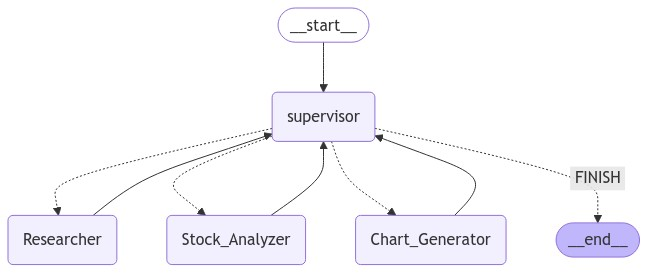

In [34]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='애플(Apple Inc., AAPL) 주식에 대한 정보를 다음과 같이 요약합니다:\n\n### 1. 최근 뉴스 및 동향\n- **주가 하락**: 2023년 10월 20일 기준으로 애플 주식은 하락세를 보이고 있으며, 현재 주가는 약 $173입니다. (출처: [WSJ](https://www.wsj.com/livecoverage/stock-market-today-dow-jones-10-20-2023/card/apple-stock-is-on-a-losing-streak-KvUAOvnDUIrjnXy6BT99))\n- **신제품 발표**: 애플은 10월에 새로운 실리콘 칩 M3를 발표할 예정이며, 이는 회사의 기술 혁신을 나타내는 중요한 이정표가 될 것입니다. (출처: [CNN](https://www.cnn.com/2023/10/24/tech/apple-october-event-2023/index.html))\n\n### 2. 주식 분석\n- **과대 평가 우려**: 현재 애플 주식은 약간 과대 평가된 상태로 보이며, 향후 주가는 약간 하락할 가능성이 있습니다. (출처: [NASDAQ](https://www.nasdaq.com/articles/up-34-this-year-will-apple-stock-rally-further-following-q4-results))\n- **애널리스트 의견**: 29명의 애널리스트가 제시한 12개월 목표가는 평균 $242.21로 예상되며, 이는 현재 주가에서 약 6.95% 상승할 것으로 보입니다. (출처: [StockAnalysis](https://stockanalysis.com/stocks/aapl/forecast/))\n\n### 3. 가격 예측\n- **애널리스트 가격 목표**: 애플 주식의 12개월 가격 목표는 최소 $180에서 최대 $300까지 다양하게 제시되

Python REPL can execute arbitrary code. Use with caution.
<string>:24: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
<string>:24: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
<string>:24: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
<string>:24: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
<string>:24: UserWarning: Glyph 50528 (\N{HANGUL SYLLABLE AE}) missing from font(s) DejaVu Sans.
<string>:24: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
<string>:24: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
<string>:24: UserWarning: Glyph 44540 (\N{HANGUL SYLLABLE GEUN}) missing from font(s) DejaVu Sans.
<string>:24: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
<string>:24: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GA

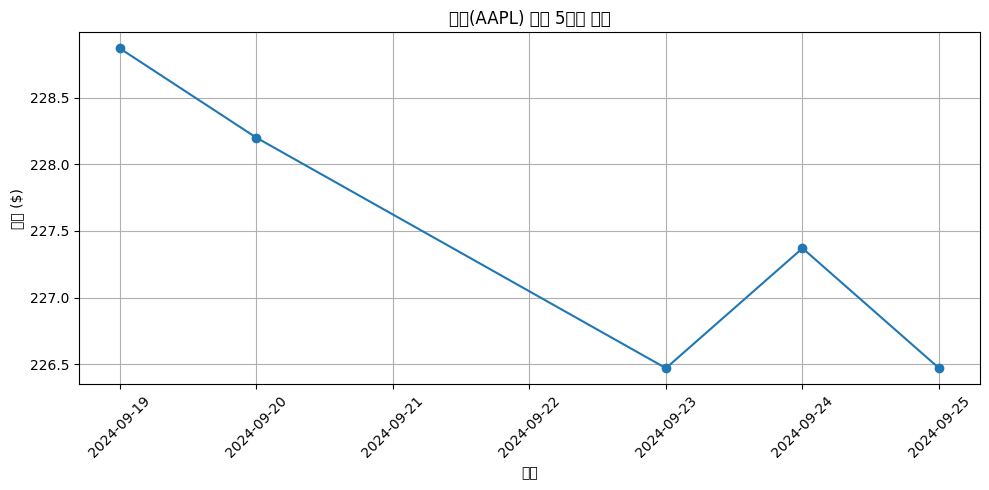

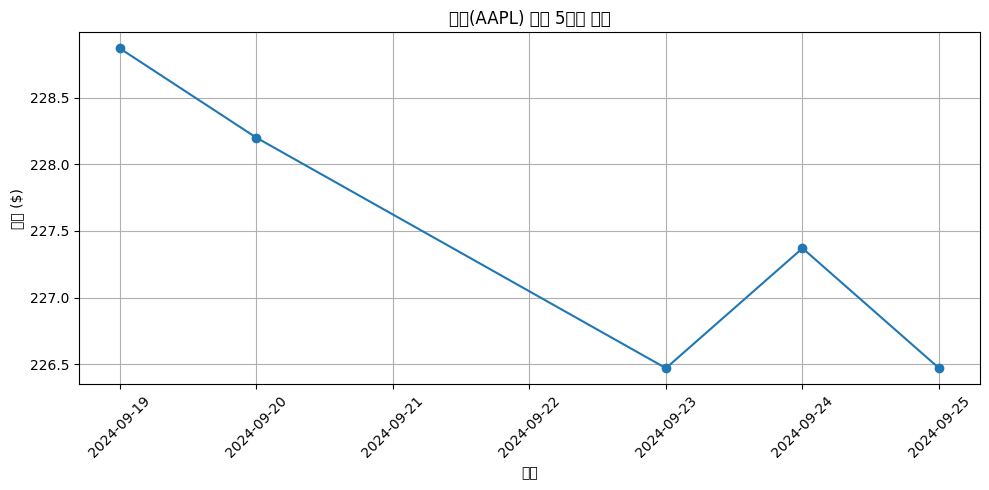

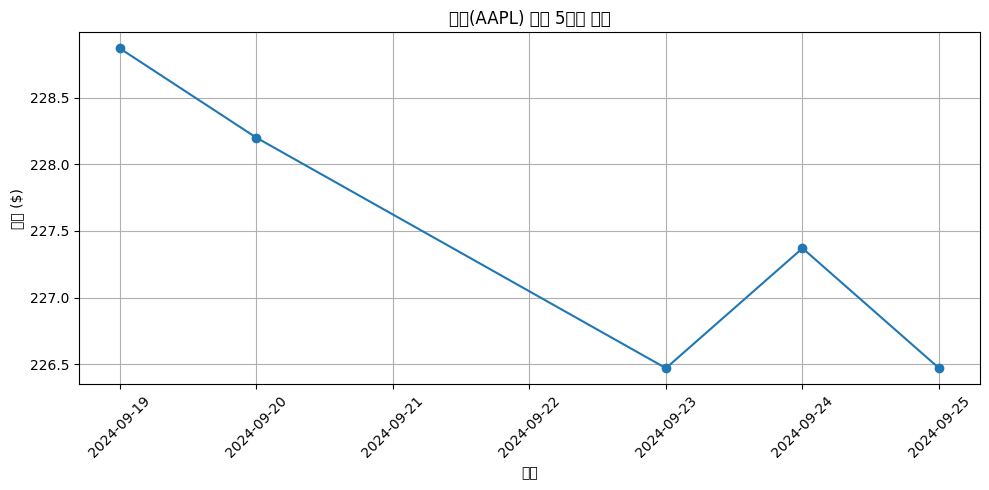

{'Chart_Generator': {'messages': [HumanMessage(content='최근 5일간 애플(AAPL) 주식의 종가 차트를 생성했습니다. 차트는 다음과 같습니다:\n\n- 날짜: 2024-09-19부터 2024-09-25까지\n- 종가: 각각 $228.87, $228.20, $226.47, $227.37, $226.47\n\n차트를 통해 주가의 동향을 시각적으로 확인할 수 있습니다. 주가 변동을 분석하는 데 도움이 되길 바랍니다.', additional_kwargs={}, response_metadata={}, name='Chart_Generator')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [35]:
for s in graph.stream({"messages": [HumanMessage(content="애플 주식 구매 의사 결정 도와줘")]}):
    if "__end__" not in s:
        print(s)
        print("----")